# QLSTM Testing
This document conducts basic test fits on time series curves. Later we also introduce noise to the equation.

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from q_lstm_tf import QLSTM
from q_lstm_tf_v2 import QLSTM as QLSTM_V2
from q_lstm_tf_v2_data_reuploaded import QLSTM as QLSTM_REUPLOAD
import keras
from quantum.util.dataset_creator import create_dataset
import tensorflow.experimental.numpy as np
tf.keras.backend.set_floatx('float64')
import pennylane as qml
from model_saver import ModelSaver
from lbfgs_trainer import Lbfgs
import pickle

dtype_global = tf.float64
tf.random.set_seed(42)


Using Quantum Device: <lightning.qubit device (wires=2) at 0x17c57828790>


Lets start by fitting a simple sinusoid:

In [2]:
X, y = create_dataset(tf.sin, sample_count=100, dtype=dtype_global, end=6*np.pi)
dataset = tf.data.Dataset.from_tensor_slices((X, y))

dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the data
dataset = dataset.batch(32)                 # Batch size of 32
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for performance

qubits = 2
dev = qml.device('lightning.qubit', wires=qubits)

### Plot Train data

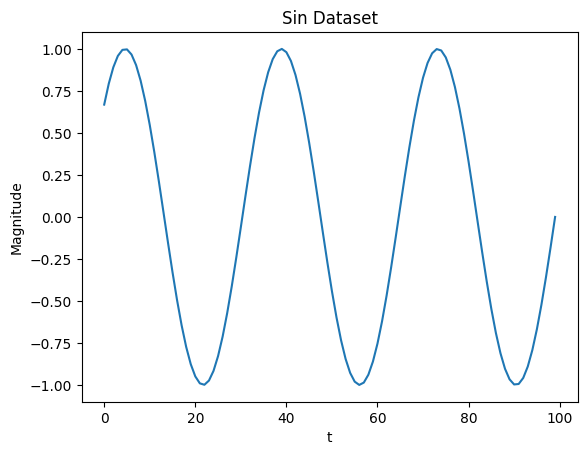

In [3]:
plt.plot(y)
plt.title("Sin Dataset")
plt.xlabel('t')
plt.ylabel('Magnitude')
plt.show()

### Create trainers for LSTM and QLSTM

In [ ]:
histoies = []
for qlstm_class in [("qlstm", QLSTM), ("qlstm_v2", QLSTM_V2), ("qlstm_reupload", QLSTM_REUPLOAD)]:
    for qubits in [3]:
        for layers in [4, 5, 6]:
            for lr in [0.01]:
                model_save_path = f"testing/model_{qlstm_class[0]}_qubits_{qubits}_layers_{layers}_lr_{lr}.h5"
                print(f"Training {qlstm_class[0]} with {qubits} qubits, {layers} layers, learning rate {lr}")
                dev = qml.device('lightning.qubit', wires=qubits)
                model_saver = ModelSaver(model_save_path)
                model = tf.keras.Sequential([
                    qlstm_class[1](qubits, dev=dev, layers=layers, dtype=dtype_global, return_sequences=False)
                ])
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                model.compile(
                    optimizer=optimizer,
                    loss='mse'
                )
                history = model.fit(
                    dataset,
                    validation_data=dataset,
                    epochs=50,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=2),
                        model_saver
                    ]
                )
                
                histoies.append((qlstm_class[0], qubits, layers, lr, history))
                pickle.dump(histoies, open("testing/histories.pickle", "wb"))
        

                
                


# model = tf.keras.Sequential([QLSTM(1, dev=dev, layers=4, wires=qubits, dtype=dtype_global, return_sequences=False)])
# optimizer = tf.keras.optimizers.Adam(learning_rate=.01)

# model.compile(optimizer=optimizer, loss='mse')
# history_q = model.fit(
#     dataset,
#     validation_data=dataset,
#     epochs=50,
#     callbacks=tf.keras.callbacks.EarlyStopping(monitor="auto", verbose=1, patience=2),
#     )

Training qlstm with 3 qubits, 4 layers, learning rate 0.01
Epoch 1/50
4/4 [==============================] - 18s 5s/step - loss: 0.7226 - val_loss: 0.5881
Epoch 2/50
4/4 [==============================] - 18s 5s/step - loss: 0.5613 - val_loss: 0.5140
Epoch 3/50
4/4 [==============================] - 18s 5s/step - loss: 0.5079 - val_loss: 0.4997
Epoch 4/50
4/4 [==============================] - 18s 5s/step - loss: 0.4992 - val_loss: 0.5009
Epoch 5/50
4/4 [==============================] - 18s 5s/step - loss: 0.5004 - val_loss: 0.4999
Epoch 5: early stopping
Training qlstm with 3 qubits, 5 layers, learning rate 0.01
Epoch 1/50
4/4 [==============================] - 20s 5s/step - loss: 0.5344 - val_loss: 0.5030
Epoch 2/50
4/4 [==============================] - 20s 5s/step - loss: 0.4949 - val_loss: 0.4745
Epoch 3/50
4/4 [==============================] - 20s 5s/step - loss: 0.4664 - val_loss: 0.4441
Epoch 4/50
4/4 [==============================] - 20s 5s/step - loss: 0.4354 - val_loss: 0

In [ ]:
history = trainer.train()

Epoch 1/5
Batch 1/4, Loss: 0.166285472045396 Batch time: 33.449036836624146
Batch 2/4, Loss: 0.12245990794477832 Batch time: 26.44277048110962
Batch 3/4, Loss: 0.0655388435388579 Batch time: 31.960017681121826
Batch 4/4, Loss: 0.027387357231049674 Batch time: 18.628912210464478
Epoch time: 110.49273896217346
Epoch 2/5
Batch 1/4, Loss: 0.05593736926833463 Batch time: 48.28673076629639
Batch 2/4, Loss: 0.062114608482764636 Batch time: 72.56227254867554
Batch 3/4, Loss: 0.0574830838232941 Batch time: 74.06053972244263
Batch 4/4, Loss: 0.00648867717732908 Batch time: 30.843688011169434
Epoch time: 225.7612280845642
Epoch 3/5
Batch 1/4, Loss: 0.0610209721944356 Batch time: 24.492044687271118
Batch 2/4, Loss: 0.05628499745411459 Batch time: 83.03089547157288
Batch 3/4, Loss: 0.046980103294944814 Batch time: 62.487167835235596
Batch 4/4, Loss: 0.022417921581281974 Batch time: 58.4257595539093
Epoch time: 228.4418683052063
Epoch 4/5
Batch 1/4, Loss: 0.05507650871642833 Batch time: 57.147104024

Text(0.5, 1.0, 'Sine loss of QLSTM with 2')

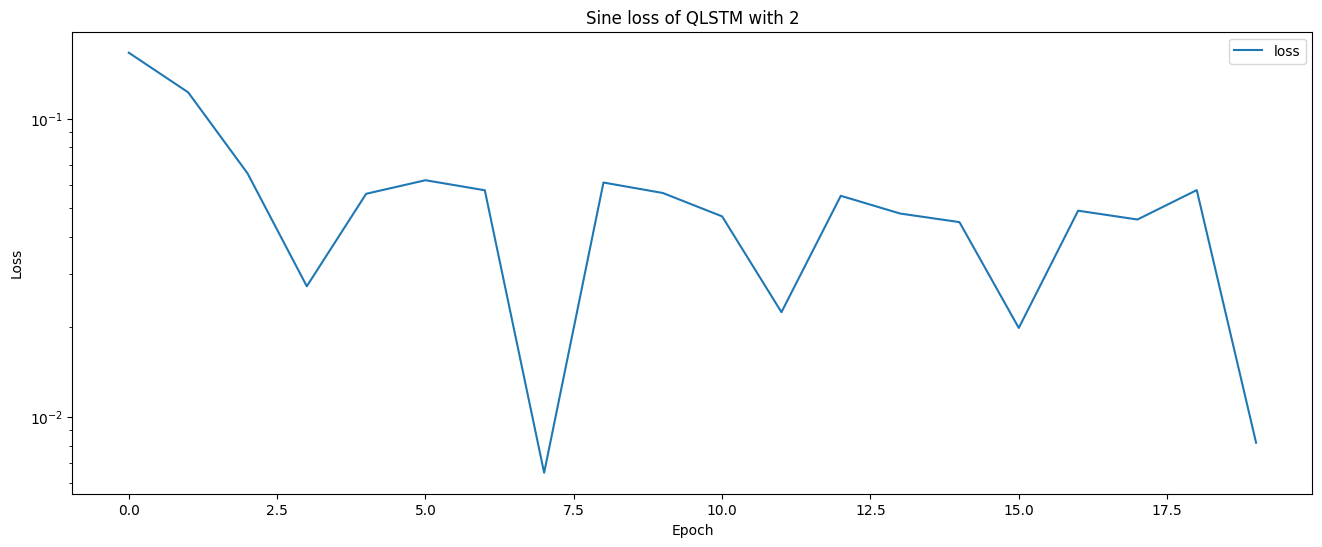

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(history)
plt.legend(['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title(f"Sine loss of QLSTM with {qubits}")

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.LSTM(64, dtype=dtype_global, return_sequences=False)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(
    dataset,
    validation_data=dataset,
    epochs=300,
    callbacks=
    [
        tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
        ModelSaver("testing/classical_lstm_sin.h5")
    ]
)

Epoch 1/300
4/4 [==============================] - 1s 83ms/step - loss: 0.5220 - val_loss: 0.5170
Epoch 2/300
4/4 [==============================] - 0s 7ms/step - loss: 0.5152 - val_loss: 0.5103
Epoch 3/300
4/4 [==============================] - 0s 7ms/step - loss: 0.5085 - val_loss: 0.5039
Epoch 4/300
4/4 [==============================] - 0s 10ms/step - loss: 0.5023 - val_loss: 0.4976
Epoch 5/300
4/4 [==============================] - 0s 7ms/step - loss: 0.4960 - val_loss: 0.4916
Epoch 6/300
4/4 [==============================] - 0s 7ms/step - loss: 0.4902 - val_loss: 0.4855
Epoch 7/300
4/4 [==============================] - 0s 7ms/step - loss: 0.4840 - val_loss: 0.4793
Epoch 8/300
4/4 [==============================] - 0s 7ms/step - loss: 0.4777 - val_loss: 0.4728
Epoch 9/300
4/4 [==============================] - 0s 7ms/step - loss: 0.4712 - val_loss: 0.4660
Epoch 10/300
4/4 [==============================] - 0s 7ms/step - loss: 0.4642 - val_loss: 0.4584
Epoch 11/300
4/4 [=========

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
Total params: 66560 (520.00 KB)
Trainable params: 66560 (520.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ValueError: x and y must have same first dimension, but have shapes (50,) and (300,)

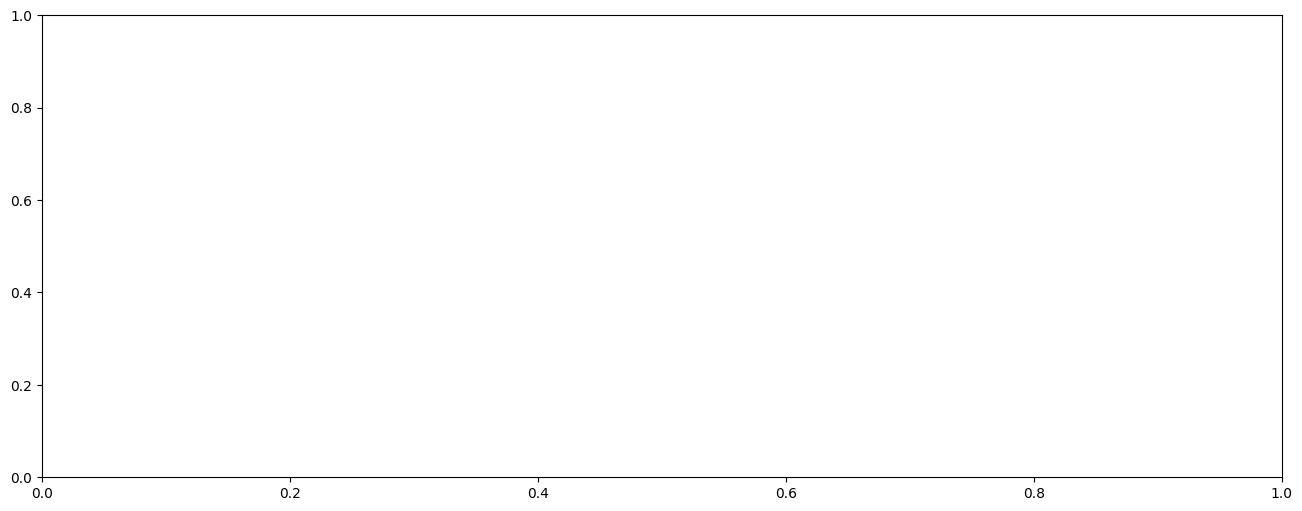

In [ ]:
metrics = history.history
q_metrics = history_q.history
plt.figure(figsize=(16,6))
plt.plot(history_q.epoch, metrics['loss'], q_metrics['loss'])

plt.legend(['LSTM loss', 'QLSTM loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title(f"Sine loss")

In [3]:
X, y = create_dataset(lambda x: tf.exp(-0.25*x) * tf.sin(4.0*x), sample_count=100, dtype=dtype_global)

dataset_basel = tf.data.Dataset.from_tensor_slices((X, y))

dataset_basel = dataset_basel.shuffle(buffer_size=1000)  # Shuffle the data
dataset_basel = dataset_basel.batch(100)                 # Batch size of 32
dataset_basel = dataset_basel.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for performance

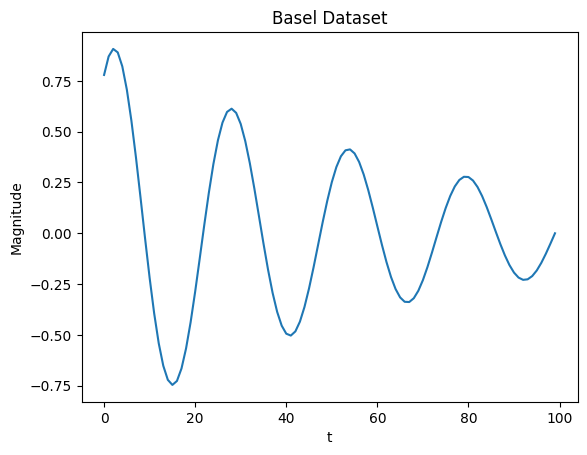

In [ ]:
plt.plot(y)
plt.title("Basel Dataset")
plt.xlabel('t')
plt.ylabel('Magnitude')
plt.show()

In [4]:
histoies = []
for qlstm_class in [("qlstm", QLSTM), ("qlstm_v2", QLSTM_V2), ("qlstm_reupload", QLSTM_REUPLOAD)]:
    for qubits in [4, 5, 6]:
        for layers in [1]:
            for lr in [0.01]:
                model_save_path = f"testing/model_{qlstm_class[0]}_qubits_{qubits}_layers_{layers}_lr_{lr}_basel.h5"
                print(f"Training {qlstm_class[0]} with {qubits} qubits, {layers} layers, learning rate {lr}")
                dev = qml.device('lightning.qubit', wires=qubits)
                model_saver = ModelSaver(model_save_path)
                model = tf.keras.Sequential([
                    qlstm_class[1](qubits, dev=dev, layers=layers, dtype=dtype_global, return_sequences=False)
                ])
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                model.compile(
                    optimizer=optimizer,
                    loss='mse'
                )
                history = model.fit(
                    dataset_basel,
                    validation_data=dataset_basel,
                    epochs=50,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=2),
                        model_saver
                    ]
                )
                
                histoies.append((qlstm_class[0], qubits, layers, lr, history))
                pickle.dump(histoies, open("testing/histories_basel.pickle", "wb"))
        


Training qlstm with 4 qubits, 1 layers, learning rate 0.01
Epoch 1/50
1/1 [==============================] - 12s 12s/step - loss: 0.3778 - val_loss: 0.3382
Epoch 2/50
1/1 [==============================] - 12s 12s/step - loss: 0.3382 - val_loss: 0.3035
Epoch 3/50
1/1 [==============================] - 12s 12s/step - loss: 0.3035 - val_loss: 0.2733
Epoch 4/50
1/1 [==============================] - 16s 16s/step - loss: 0.2733 - val_loss: 0.2475
Epoch 5/50
1/1 [==============================] - 25s 25s/step - loss: 0.2475 - val_loss: 0.2257
Epoch 6/50
1/1 [==============================] - 13s 13s/step - loss: 0.2257 - val_loss: 0.2076
Epoch 7/50
1/1 [==============================] - 13s 13s/step - loss: 0.2076 - val_loss: 0.1927
Epoch 8/50
1/1 [==============================] - 12s 12s/step - loss: 0.1927 - val_loss: 0.1808
Epoch 9/50
1/1 [==============================] - 11s 11s/step - loss: 0.1808 - val_loss: 0.1713
Epoch 10/50
1/1 [==============================] - 11s 11s/step - lo

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qlstm_1 (QLSTM)             (None, 1)                 266       
                                                                 
Total params: 266 (2.08 KB)
Trainable params: 266 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = tf.keras.Sequential([tf.keras.layers.LSTM(64, dtype=dtype_global, return_sequences=False)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(
    dataset_basel,
    validation_data=dataset_basel,
    epochs=300,
    callbacks=
    [
        tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
        ModelSaver("testing/classical_lstm_basel.h5")
    ]
)

Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 0.1460 - val_loss: 0.1456
Epoch 2/300
1/1 [==============================] - 0s 20ms/step - loss: 0.1456 - val_loss: 0.1451
Epoch 3/300
1/1 [==============================] - 0s 21ms/step - loss: 0.1451 - val_loss: 0.1447
Epoch 4/300
1/1 [==============================] - 0s 19ms/step - loss: 0.1447 - val_loss: 0.1442
Epoch 5/300
1/1 [==============================] - 0s 19ms/step - loss: 0.1442 - val_loss: 0.1438
Epoch 6/300
1/1 [==============================] - 0s 20ms/step - loss: 0.1438 - val_loss: 0.1433
Epoch 7/300
1/1 [==============================] - 0s 18ms/step - loss: 0.1433 - val_loss: 0.1429
Epoch 8/300
1/1 [==============================] - 0s 18ms/step - loss: 0.1429 - val_loss: 0.1424
Epoch 9/300
1/1 [==============================] - 0s 18ms/step - loss: 0.1424 - val_loss: 0.1419
Epoch 10/300
1/1 [==============================] - 0s 19ms/step - loss: 0.1419 - val_loss: 0.1414
Epoch 11/300
1/1 [===

Text(0.5, 1.0, 'Sine Exponential loss')

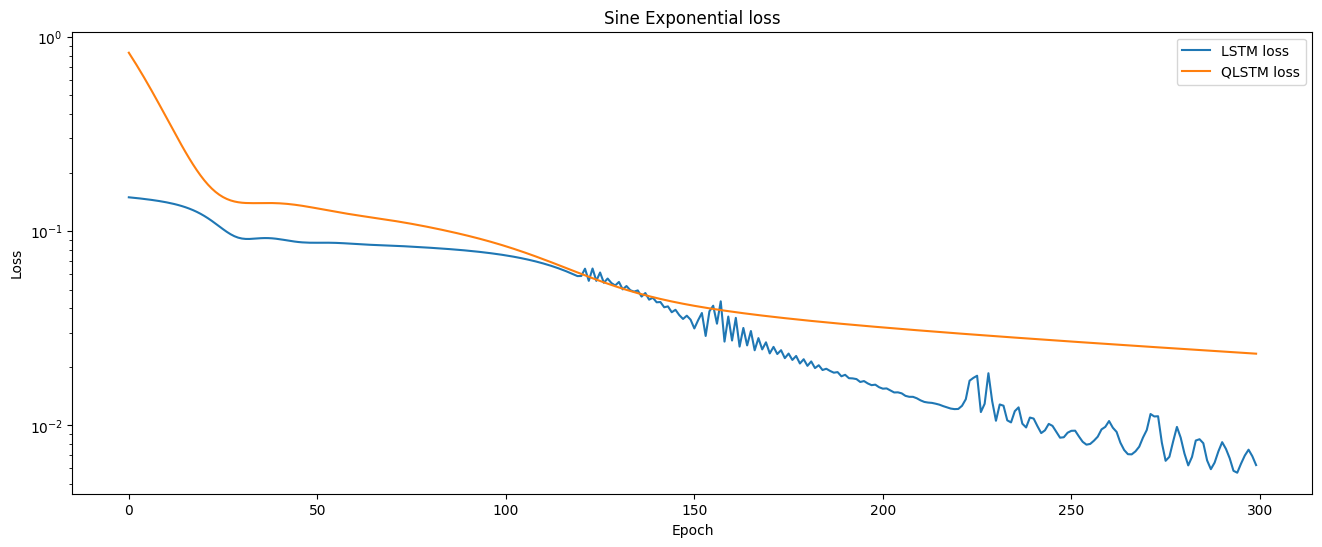

In [ ]:
metrics = history.history
q_metrics = history_q.history
plt.figure(figsize=(16,6))
plt.plot(history_q.epoch, metrics['loss'], q_metrics['loss'])

plt.legend(['LSTM loss', 'QLSTM loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title(f"Sine Exponential loss")